<img src="https://raw.githubusercontent.com/GeoscienceAustralia/dea-notebooks/stable/Supplementary_data/dea_logo_wide.jpg" 
     alt="DEA Notebooks logo" 
     style="width:80%;">

# ***Living Earth*** Exploring Landsat-5 Thematic Mapper data 

🔎 Visit [DEA's Knowledge Hub](https://knowledge.dea.ga.gov.au/) for detailed technical information about the datasets and concepts used in this notebook.

<div style="
    border-left: 6px solid var(--jp-success-color1, #4CAF50);
    background-color: rgba(76, 175, 80, 0.15);
    padding: 12px;
    border-radius: 8px;
    font-size: 1rem;
    color: var(--jp-content-font-color1);
">
<b>🚀 How you can run this notebook</b><br><br>
- <b>DEA Sandbox:</b> Eligible users can sign up for the 
<a href="https://sandbox.dea.ga.gov.au/" target="_blank">DEA Sandbox</a> 
that provides free compute and a managed Python environment.<br><br>
- <b>Personal computer:</b> This notebook loads DEA data using <code>odc-stac</code>. 
Data streams via the internet, so can be run locally after installing the required 
<a href="https://pypi.org/project/dea-tools/" target="_blank">DEA Tools</a> Python package, 
e.g. <code>pip install dea-tools[notebooks]</code>.
</div>

<div style="
    border-left: 6px solid var(--jp-info-color1, #2196F3);
    background-color: rgba(33, 150, 243, 0.15);
    padding: 12px;
    border-radius: 8px;
    font-size: 1rem;
    color: var(--jp-content-font-color1);
">
<b>📦 Products used:</b><br>
<a href="https://explorer.dea.ga.gov.au/products/ga_ls5t_ard_3" target="_blank">ga_ls5t_ard_3</a>
</div>



## Landsat-5 Thematic Mapper (TM) data.
The Landsat-5 Thematic Mapper (TM) was launched jointly by the United States (US) National Aeronautics and Space Administration (NASA) and the US Geological Survey (USGS) on **01 Mar 1984** and was decommissioned on **05 Jun 2013**.   

The Landsat TM recorded reflected solar  energy in seven wavebands (visible (blue, green, red), near infrared and shortwave infrared (2 wavebands)).

The repeat cycle was every 16 days although useable observations depended upon the presence of cloud and/or smoke and associated shadowing.  

For more information on the Landsat-5 TM, visit https://database.eohandbook.com/database/missionsummary.aspx?missionID=226.

## Description
This notebook demonstrates how to access and view Landsat-5 Thematic Mapper (TM) optical data within Digital Earth Australia (DEA; https://www.ga.gov.au/scientific-topics/dea) and through the Open Data Cube (www.opendata.org).  Also, consult the DEA Knowledge Hub (https://knowledge.dea.ga.gov.au/guides/setup/dea_maps/)

Topics covered in this notebook include:

1. Choosing an area of interest (we have chosen Hinchinbrook Island in Queensland, but you can select either area or another).
2. Loading Landsat-5 TM data for the selected area, and for different time windows, and reviewing the different wavebands of this sensor.
3. Displaying the Landsat TM images in various band combinations and exploring images over time.
4. Calculating and displaying a simple index, in this case the Normalised Difference Vegetation Index (NDVI), from the image data: a) within the notebook as (i) standalone calculation and (ii) as a function (referenced in python as `def`) and c) outside of the notebook.
5. Displaying NDVI images from one and several dates.
6. Exporting the data as a Geotiff for further analysis (e.g., within ARCGIS or QGIS).

***

### Load packages
The cell below imports Python packages that are used for the analysis.
`%matplotlib inline` ensures figures are plot correctly in the Jupyter notebook.
The following commands import various functionality: 

* `sys` provides access to helpful support functions in the `dea_plotting` module. 
* `datacube` provides the ability to query and load data.
* `matplotlib` provides the ability to format and manipulate plots.

In [1]:
%matplotlib inline

import sys
import pystac_client
import odc.stac

from odc.geo import BoundingBox
from odc.geo.cog import write_cog
from odc.geo.xr import assign_crs

import matplotlib.pyplot as plt
from dea_tools.plotting import display_map, rgb

## Connect to DEA's STAC API
This allows us to search for data using DEA's STAC API (refer to the SpatioTemporal Asset Catalogue guide for details).

To load data, we must also configure access to DEA's Amazon S3 buckets using `odc.stac.configure_s3_access`. If launching a Dask client with `dea_tools.dask.create_local_dask_cluster()`, this is done automatically.

In [2]:
# Configure data access
odc.stac.configure_s3_access(cloud_defaults=True, aws_unsigned=True)

# Connect to STAC API
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

## Step 1: Choose a study area

When working with the Open Data Cube, it's important to load only as much data as needed.
This helps keep an analysis running quickly and avoids the notebook crashing due to insufficient memory.

One way to set the study area is to set a central latitude and longitude coordinate pair, `(central_lat, central_lon)`, then specify how many degrees to include either side of the central latitude and longitude, known as the `buffer`.
Together, these parameters specify a square study area

## Location
### Area selection
Below, we have set the study area covering Hinchinbrook, Queensland, although you can select any area in Australia.
To load a different area, you can provide your own `central_lat` and `central_lon` values.
One way to source these is to Google a location, or click directly on the map in [Google Maps](https://www.google.com/maps/@-43.4539764,146.5660989,11642m/data=!3m1!1e3).

* **Hinchinbrook Island, Queensland**
```
central_lat = -18.34
central_lon = 146.17
```

> **Note**: If you change the study area latitude and longitude, you'll need to re-run all of the cells after to apply that change to the whole analysis.

### A note on Hinchinbrook Island
Hinchinbrook Island is located in Far North Queensland (see https://en.wikipedia.org/wiki/Hinchinbrook_Island) and is Australia's largest island national park and also the largest on the Great Barrier Reef.   Whilst supporting an exceptional diversity of pristine habitats, the integrity of these has been affected by a number of natural events and processes including tropical cyclones with Cyclone Yasi exerting considerable impact when it landsed as a category 5 on February 3 2011 (see https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.4485.  The changing states and dynamics of Hinchinbrook can be observed in the time-series of Landsat sensor data. 

### Buffer
Feel free to experiment with the `buffer` value to load different sized areas.
We recommend that you keep the `buffer` relatively small, no higher than **`buffer=0.1`** degrees.
This will help keep the loading times reasonable and prevent the notebook from crashing.

> **Extension**: Can you modify the code to use a different `buffer` value for latitude and longitude? 

> *Hint*: You may want two variables, `buffer_lat` and `buffer_lon` that you can set independently. You'll then need to update the definitions of `study_area_lat` and `study_area_lon` with their corresponding buffer value.

In [3]:
# Set the central latitude and longitude
central_lat = -18.4
central_lon = 146.17

# Set the buffer to load around the central coordinates
buffer=0.05

After choosing the study area, it can be useful to visualise it on an interactive map.
This provides a sense of scale.
> **Note**: The interactive map also returns latitude and longitude values when clicked.
You can use this to generate new latitude and longitude values to try without leaving the notebook.

In [4]:
# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Loading Landsat sensor data

### Important information to consider before loading the Landsat sensor data.
The Landsat TM has a  resolution; the [DEA collection](https://explorer.dea.ga.gov.au/products/ga_ls5t_ard_3) and data were acquired from **01 Mar 1984** and was decommissioned on **05 Jun 2013**. Note these dates as this is important to be within this time interval when selecting your data for display.

### Set the product, the time, wavebands, resolutions and coordinate systems.
Note that you can amend these parameters.  Try not to load an extended time-series as this will take time to process.  Here, we have set the dates to be in 1988 and in the dry season (May to October) when there is a greater likelihood of cloud-free conditions.

In [5]:
# Set the data source
# Note the time-periods below.  
product = "ga_ls5t_ard_3"

# Set the date range to load data over.
# Note that Landsat-5 Thematic Mapper (TM) was launched by the United States 
# Geological Survey (USGS) on **01 Mar 1984** and was decommissioned on **05 Jun 2013**.
time = ("1988-05-01", "1989-06-30")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
measurements = [
    "nbart_red",
    "nbart_blue",
    "nbart_green",
    "nbart_nir",
    "nbart_swir_1",   
]

# Set the coordinate reference system and output resolution
# This choice corresponds to Australian Albers, with resolution in metres
crs = "epsg:3577"
resolution = 30

In [6]:
#set up a bounding box for our stac query 
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs=crs
)
bbox_query = bbox.bbox

# Search the catalog for matching S2 data
query = catalog.search(
    bbox=bbox_query,
    collections=[product],
    datetime=time
    )

items = list(query.items()) #convert to list
print(f"Found: {len(items):d} datasets")

Found: 25 datasets


After setting all of the necessary parameters, the `dc.load()` command is used to load the data:

In [7]:
#now load the data with odc-stac
ds = odc.stac.load(
    items, #stac items
    bands=measurements, #bands of data to load
    crs=crs,
    resolution=resolution,
    groupby="solar_day",
    bbox=bbox, #area to load over
)

Following the load step, printing the `ds` `xarray.Dataset` object will give you insight into all of the data that was loaded.
Do this by running the next cell.

There's a lot of information to unpack, which is represented by the following aspects of the data:
- `Dimensions`: the names of data dimensions, frequently `time`, `x` and `y`, and number of entries in each
- `Coordinates`: the coordinate values for each point in the data cube
- `Data variables`: the observations loaded, typicallu different spectral bands from a satellite
- `Attributes`: additional useful information about the data, such as the `crs` (coordinate reference system)

In [8]:
ds

<xarray.Dataset> Size: 80MB
Dimensions:       (y: 407, x: 391, time: 25)
Coordinates:
  * y             (y) float64 3kB -2.043e+06 -2.043e+06 ... -2.055e+06
  * x             (x) float64 3kB 1.487e+06 1.487e+06 ... 1.499e+06 1.499e+06
    spatial_ref   int32 4B 3577
  * time          (time) datetime64[ns] 200B 1988-05-02T23:47:03.333094 ... 1...
Data variables:
    nbart_red     (time, y, x) float32 16MB 336.0 336.0 ... 2.353e+03 1.722e+03
    nbart_blue    (time, y, x) float32 16MB 465.0 401.0 ... 2.075e+03 1.555e+03
    nbart_green   (time, y, x) float32 16MB 508.0 508.0 ... 2.185e+03 1.698e+03
    nbart_nir     (time, y, x) float32 16MB 197.0 197.0 ... 3.286e+03 2.78e+03
    nbart_swir_1  (time, y, x) float32 16MB 53.0 53.0 ... 3.259e+03 2.513e+03

## Step 3: Plotting image data
### Selecting time-steps and band combinations
After loading the data, it is useful to view it to understand the resolution, which observations are impacted by cloud cover, and whether there are any obvious differences between time steps.

Use the `rgb()` function to plot the data loaded in the previous step.
The `rgb()` function maps three data variables/measurements from the loaded dataset to the red, green and blue channels that are used to make a three-colour image.
There are several parameters you can experiment with:

* `time_step=n`\
This sets the time step you want to view. 
`n` can be any number from `0` to one fewer than the number of time steps you loaded. 
The number of time steps loaded is given in the print-out of the data, under the `Dimensions` heading. 
As an example, if under `Dimensions:` you see `time: 6`, then there are 6 time steps, and `time_step` can be any number between `0` and `5`.  Note that the `time_step` can `-1` or `-7` when you want to go to the end of the series of the 7th last image (for example).

* `bands = [red_channel, green_channel, blue_channel]`\
This sets the measurements that you want to use to make the image.
Any measurements can be mapped to the three channels, and different combinations highlight different features.
Three common combinations are
    * true colour: 
    `bands = ["nbart_red", "nbart_green", "nbart_blue"]`
    * false colour 1: `bands = ["nbart_nir", "nbart_red", "nbart_green"]`
    * false colour 2: 'bands = ["nbart_nir", "nbart_swir_1", "nbart_red"]
    
For more detail about customising plots, see the [Introduction to plotting](05_Plotting.ipynb) notebook.  
Experiment with the different combinations of bands.

> **Extension**: If `time_step` is set to an array of values, e.g. `time_step=[time_1, time_2]`, it will plot all provided time steps.
See if you can modify the code to plot the first and last images.
If you do, what changes do you notice?

> *Hint*: To get the last image, and as indicated above, you can use a time step value of `-1`

### Displaying the image data for selected time periods
By using the time steps of 1 (second image) and -2 and -1 (second from last and last respectively), you can display the images in the band combination of choice (e.g., near infrared, shortwave infrared and red).  Experiment with the selection of wavebands (note also you can include the blue, green and red bands as well as the second shortwave infrared band (i.e., swir_2) but you will need to reset the product load.

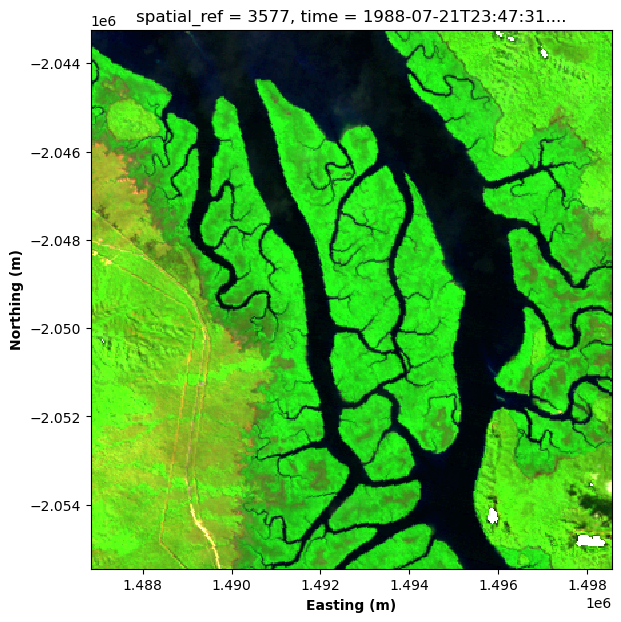

In [10]:
# Set the time step to view
time_step = [5]

# Set the band combination to plot -false colour!
bands = ["nbart_swir_1", "nbart_nir", "nbart_green"]

# Generate the image by running the rgb function
rgb(ds, bands=bands, index=time_step, size=7)

# Set the title and axis labels
ax = plt.gca()
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold');

### Displaying all images.
It would be useful to see all images so that you can select those that are either completely or relatively free of cloud.

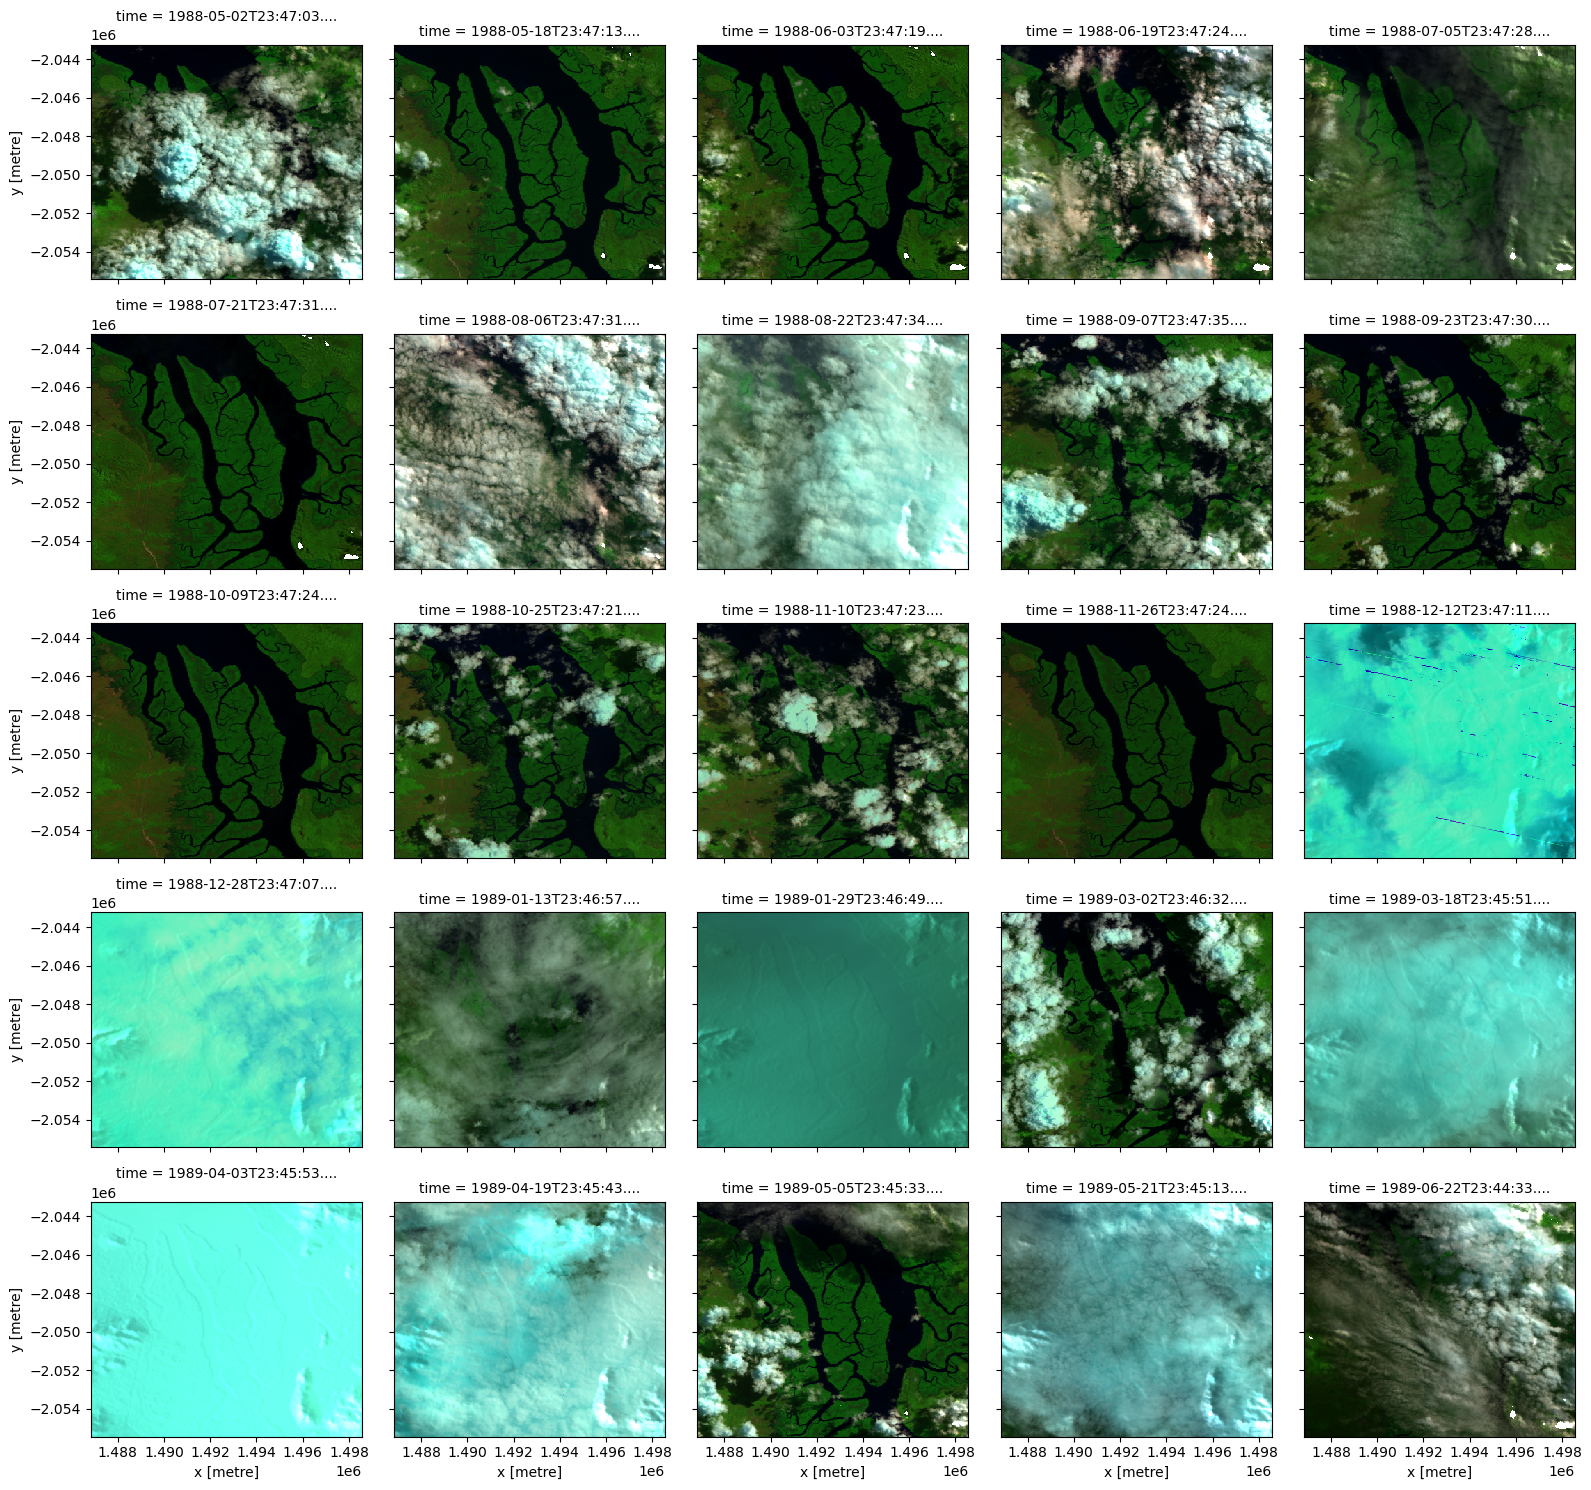

In [11]:
ds[bands].to_array().plot.imshow(col='time', col_wrap=5, robust=True, add_labels=False);

## Step 4: Calculate spectral indices from Landsat sensor data

As with data from all optical sensors recording reflected energy, you can calculate a range of spectral indices (see https://www.nv5geospatialsoftware.com/docs/AlphabeticalListSpectralIndices.html).  In this case, we will use the[Normalised Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI) which can indicate the presence and relative health of vegetation, with this defined as:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})}, \\
\end{aligned}
$$

where $\text{NIR}$ is the near-infrared band of the data, and $\text{Red}$ is the red band.
NDVI can take on values from -1 to 1; high values indicate healthy vegetation and negative values indicate non-vegetation (such as water). 

The following sections show how you can calculate the NDVI (and indeed any spectral index) from the image data: a) within the notebook as (i) standalone calculation and (ii) as a function (referenced in python as `def`) and c) outside of the notebook.

### Calculate the NDVI directly within a cell
Within the cell, you can calculate using simple band maths.

In [12]:
# Determine the difference between the near infrared and red bands, noting that:
#  a) the near infrared is generally high for healthy vegetation because of scattering within the cells and intercellular spaces.
#  b) the red reflectance is lower because of absorption by photosynthetic pigments

band_diff = ds.nbart_nir - ds.nbart_red

# Determine the sum of the near infrared and red reflectance.

band_sum = ds.nbart_nir + ds.nbart_red

# Normalise by dividing the band difference by the sum, which this giving values ranging from -1 to +1.
# As a rule, values above 0 indicate the presence of vegetation but as a consequence of the spatial resolution of sensors (e.g., 10-30 m)
# values of ~ 0.2 or above are often used although this varies and can be quite subjective.  

ndvi = band_diff / band_sum

After calculating the NDVI values, plot them by adding the `.plot()` method to `ndvi` (the variable that the values are stored in).
The code below will plot a single image, based on the time selected with the `ndvi_time_step` variable.
Try changing this value to plot the NDVI map at different time steps.
Do you notice any differences?

> **Extension 1**: Sometimes, it is valuable to change the colour scale to something that helps with intuitively understanding the image.
For example, the "viridis" colour map shows high values in greens/yellows (mapping to vegetation), and low values in blue (mapping to water).
Try modifying the `.plot(cmap="RdYlGn")` command below to use `cmap="viridis"` instead.

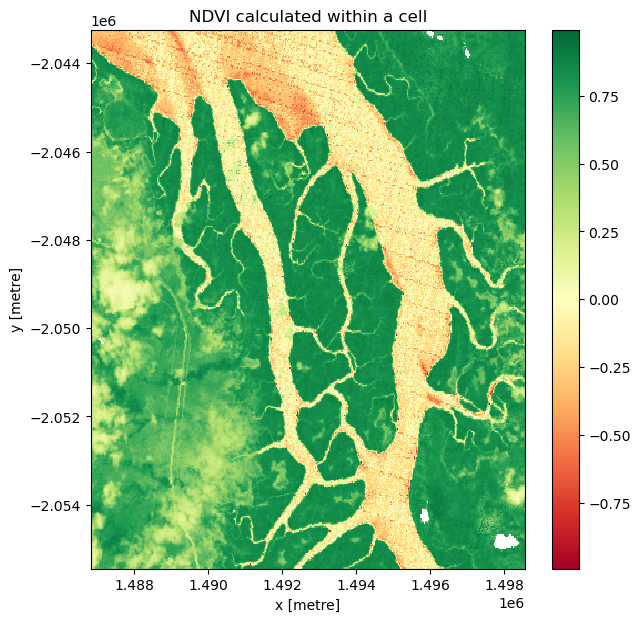

In [13]:
# Set the NDVI time step to view
ndvi_time_step = 2

# This is the simple way to plot
# Note that high values are likely to be vegetation.
plt.figure(figsize=(7, 7))
ndvi.isel(time=ndvi_time_step).plot(cmap="RdYlGn")
plt.title('NDVI calculated within a cell');

A time step is selected using the `.isel()` method. However, all time steps can be plotted by removing the `.isel()` method, and modifying the `.plot()` method to be `.plot(col="time", col_wrap=3)`.
Plotting all of the time steps at once may make it easier to notice differences in vegetation over time.  Try this out below.  Note that vegetated areas are green (a positive NDVI) whilst cloud, water and bare areas have an NDVI that is generally below 0.0.

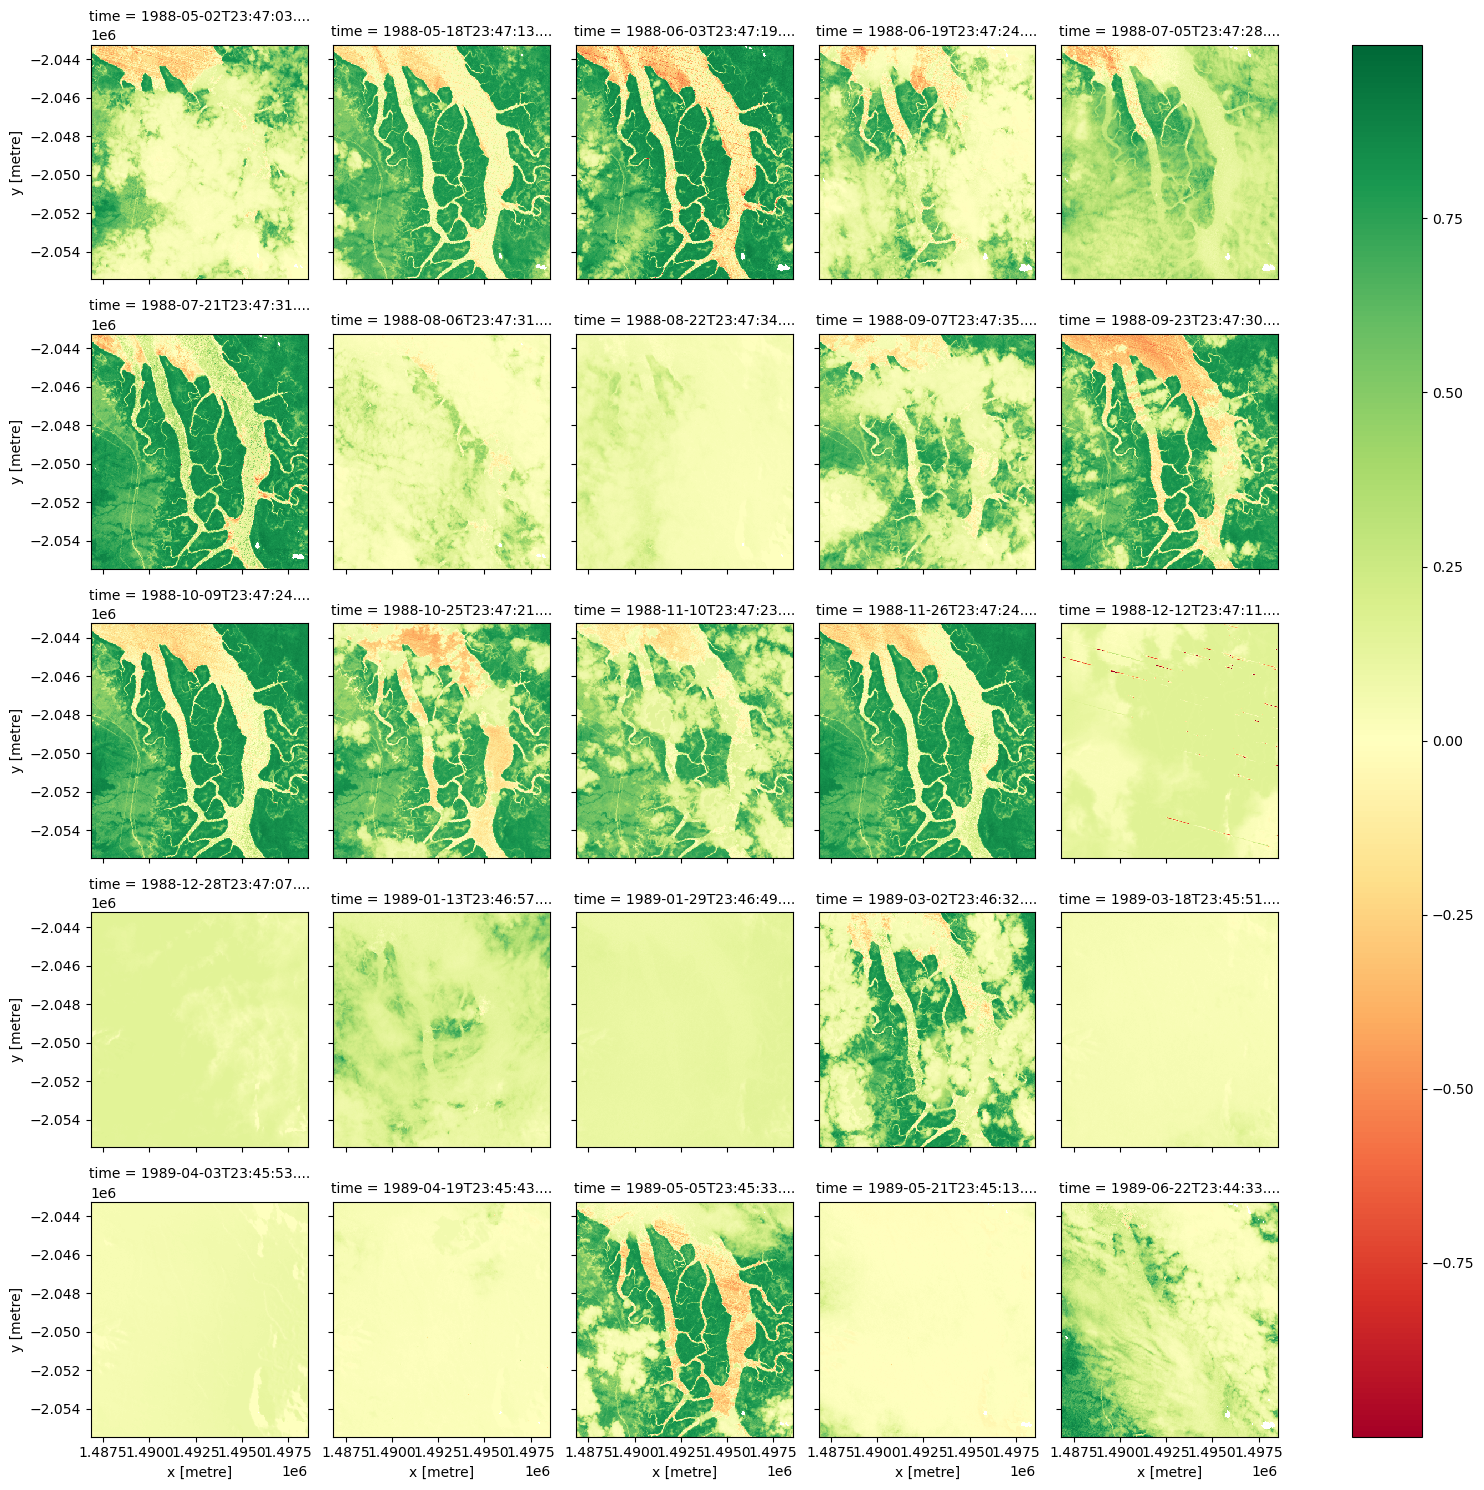

In [14]:
ndvi.plot(col="time", col_wrap=5, cmap="RdYlGn");

### Writing a simple function within a notebook.
Instead of calculating the NDVI directly within the cell, write a simple function (referenced in python as `def`) 

This can be written as:
`def normalised_index(a,b):
    return ((a-b)/(a+b))`) 

In [15]:
def normalised_index(a,b):
    return ((a-b)/(a+b))

Instead of stating the names of the layers (i.e., nbart_nir and nbart_red) in the calculation, you can reference these as a and b.

In [16]:
ndvi = normalised_index(ds.nbart_nir, ds.nbart_red)

Change (or retain) the time step and then view the resulting image.

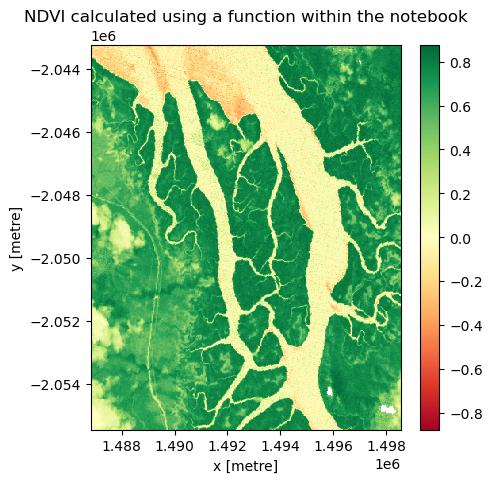

In [17]:
# Set the NDVI time step to view
ndvi_time_step = 1

# This is the simple way to plot
# Note that high values are likely to be vegetation.
plt.figure(figsize=(5, 5))
ndvi.isel(time=ndvi_time_step).plot(cmap="RdYlGn")
plt.title('NDVI calculated using a function within the notebook')
plt.show()

### Writing a function outside of the notebook.
You can also put the function into a separate file and call this from the notebook. This means that ***functions*** you use or create can be held outside of the notebook.  These functions can be simple (as in the case of a spectral index calculation, but can also be quite complex().  Having functions outside of the notebook cleaner but also allows re-use.

A file with functions normally has the extension **.py** (e.g., myfunctions.ipynb).

However, we are going to create this initially by creating an empty notebook called "myfunctions.ipynb".  You do this by selecting the "+" button.

**NOTE: You can use and add into this through the course to store your functions.**

Once created, type the function as:

def normalised_index(a,b):
    return ((a-b)/(a+b))
    
Then, export this notebook as a python script using 'File', then 'Save and export notebook as' and then select 'Executable script'.  Call it *"myfunctions.py"* and then load this into a directory (e.g., Laboratory 2).

You can then call this within any notebook using:

from myfunctions import normalised_index
ndvi = normalised_index(ds.nbart_nir, ds.nbart_red)

This will calculate the Normalised Difference Vegetation Index (NDVI), although could be modified to generate any index based on two satellite wavebands.


In [18]:
# from myfunctions import normalised_index
# ndvi = normalised_index(ds.nbart_nir, ds.nbart_red)

Change (or retain) the time step and then view the resulting image.

In [19]:
# # Set the NDVI time step to view
# ndvi_time_step = 4

# # This is the simple way to plot
# # Note that high values are likely to be vegetation.
# plt.figure(figsize=(5, 5))
# ndvi.isel(time=ndvi_time_step).plot(cmap="RdYlGn")
# plt.title('NDVI calculated using a function stored outside of the notebook')
# plt.show()

This function will calculate the Normalised Difference Vegetation Index (NDVI), although could be modified to generate any index based on two satellite wavebands.

As before, you can create your time-series of NDVI values but these have been generated using the external function (i.e. in myfunctions.py).
Try colouring up using a different colour scheme (e.g., viridis or terrain). A full list of colour schemes available within [matplotlib](https://matplotlib.org/) can be found [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html).

In [20]:
# # Set the NDVI time step to view (but try a different colour scheme) 
# ndvi.plot(col="time", col_wrap=7, cmap="viridis")
# # This is the simple way to plot
# # Note that high values are likely to be vegetation.
# plt.figure(figsize=(10, 10))

# #plt.title('NDVI calculated within a cell')
# #plt.show()

## Step 5: Exporting data

Sometimes, you will want to analyse satellite imagery in a GIS program, such as QGIS.
The `write_cog()` command from the Open Data Cube library allows loaded data to be exported to GeoTIFF, a commonly used file format for geospatial data.
> **Note**: the saved file will appear in the same directory as this notebook, and it can be downloaded from here for later use.

In [21]:
# Export to a file and name accordingly. Try to standardize and so you can record the date 
filename = "Site_name_Selected_date.tiff"
time_step=3
write_cog(geo_im=ndvi.isel(time=time_step), fname=filename, overwrite=True);

## Explore more of the Landsat time-series.
Experiment with other Landsat sensors noting the time-periods of observation

ga_ls5t_ard_3 Landsat 5 (1984-2013)  
ga_ls7e_ard_3 Landsat 7 (1999-2022)  
ga_ls8c_ard_3 Landsat 8 (2013-present)  
ga_ls9c_ard_3 Landsat 9 (2021-present)  

## Recommended next steps

### For this notebook
Many of the variables used in this analysis are configurable.
We recommend returning to the beginning of the notebook and re-running the analysis with a different location, dates, measurements, and so on.
This will help give you more understanding for running your own analysis.
If you didn't try the extension activities the first time, try and work on these when you run through the notebook again.

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2025